In [2]:
import jax
import jax.numpy as jnp
import discovery as ds
import eryn
from eryn.state import State
import glob
import sys
import inspect
import typing

import numpy as np

from discovery.deterministic import fpc_fast
from discovery import matrix, const

from discoverysamplers.eryn_RJ_interface import ErynRJBridge

In [ ]:
# Building the likelihood for 1 signal for now

# The signal that's in the mock data
def makedelay_binary_evolution_nopsrterm(evolve = False):
    def delay_binary(toas, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, log10_Mc):

        # toas, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, log10_Mc = params

        """BBH residuals from Ellis et. al 2012, 2013"""

        h0 = 10**log10_h0
        f0 = 10**log10_f0

        dec, inc = jnp.arcsin(sindec), jnp.arccos(cosinc)

        # calculate antenna pattern (note: pos is pulsar sky position unit vector)
        ###########################################################################
        # Was like this before but that doesn't seem to correspond to the correct
        # return of the fpc_fast function:                               
        # fplus, fcross, cosMu = fpc_fast(pos, 0.5 * jnp.pi - dec, ra)
        ###########################################################################
        fplus, fcross = fpc_fast(pos, 0.5 * jnp.pi - dec, ra)  # careful with dec -> gwtheta conversion
        

        phi_avg = phi_earth

        tref = 0.
       
        if evolve:
            Mc = 10**log10_Mc * const.Tsun # convert to time
            f = f0 * (1 - 256/5 * Mc**(5/3) * ((jnp.pi*f0)**(8/3) *(toas - tref)))**(-3/8) # Here I'm using only pi * f_gw !!!
            phase = phi_avg + 2 * (1/32) * (1/Mc**(5/3)) * ((jnp.pi * f0)**(-5/3) - (jnp.pi * f)**(-5/3))

            #mc = Mc * const.Tsun # convert to time
            #f = f0 * ((1 - 256/5 * mc**(5/3) * (2*jnp.pi*f0)**(8/3)) *(toas - tref))**(-3/8)
            #phase = phi_avg + (1/32) * (1/mc**(5/3)) * ((2.0 * jnp.pi * f0)**(-5/3) - (2 * jnp.pi * f)**(-5/3))

            #mc = Mc * const.Tsun # convert to time
            #f = f0 * ((1 - 256/5 * Mc**(5/3) * (2*jnp.pi*f0)**(8/3)) *(toas - tref))**(-3/8)
            #phase = phi_avg + (1/32) * (1/Mc**(5/3)) * ((2.0 * jnp.pi * f0)**(-5/3) - (2 * jnp.pi * f)**(-5/3))
        else:
            phase = phi_avg + 2.0 * jnp.pi * f0 * (toas - tref)
           
        cphase, sphase = jnp.cos(phase), jnp.sin(phase)

        # fix this for no pulsarterm

        delta_sin = sphase
        delta_cos = cphase

        At = -1.0 * (1.0 + jnp.cos(inc)**2) * delta_sin
        Bt =  2.0 * jnp.cos(inc) * delta_cos

        alpha = h0 / (2 * jnp.pi * f0)

        # calculate rplus and rcross
        rplus  = alpha * (-At * jnp.cos(2 * psi) + Bt * jnp.sin(2 * psi))
        rcross = alpha * ( At * jnp.sin(2 * psi) + Bt * jnp.cos(2 * psi))

        # calculate residuals
        res = -fplus * rplus - fcross * rcross

        return res
    
    names = ["toas", "pos", "log10_h0", "log10_f0", "ra", "sindec", "cosinc", "psi", "phi_earth", "log10_Mc"]

    return delay_binary, names

# Not the signal that's in the data
def makedelay_binary_sincos(pulsarterm=False):
    delay_binary = ds.makedelay_binary(pulsarterm=False)

    def delay_binary_sincos(toas, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, log10_Mc):
             return delay_binary(toas, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, log10_Mc)

    return delay_binary_sincos

# cgw_delay = makedelay_binary_sincos()
cgw_delay, names = makedelay_binary_evolution_nopsrterm()
cwcommon = ['cw_'+n for n in names]
# cwcommon = ['cw_sindec', 'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra', 'cw_log10_Mc']

def makemodel_cgw_EPTA_new_sim(psrs):

    pslmodels = []
    tspan = ds.getspan(psrs)

    # Make a nicer verbose output:
    psrs_with_dm_gp_components = []
    psrs_with_red_components = []

    for p in psrs:
        

        model = [p.residuals, ds.makenoise_measurement(p, p.noisedict, tnequad = True), 
                 ds.makegp_timing(p, svd=True), 
                 ds.makedelay(p, cgw_delay, name='cw', common=cwcommon)]

        if p.noisedict[p.name + '_dm_gp_components']:
            model.append(ds.makegp_fourier(p, ds.powerlaw, p.noisedict[p.name + '_dm_gp_components'], 
                                           T=ds.getspan(p), name='dm_gp', fourierbasis=ds.make_dmfourierbasis(alpha = 2.0, tndm = True)))
            psrs_with_dm_gp_components.append(p.name)

        if p.noisedict[p.name + '_red_components']:
            model.append(ds.makegp_fourier(p, ds.powerlaw, p.noisedict[p.name + '_red_components'], T=tspan, name='red_noise'))
            psrs_with_red_components.append(p.name)

        pslmodels.append(ds.PulsarLikelihood(model))

    print(f"Found DM GP components for {len(psrs_with_dm_gp_components)} pulsars:")
    print(psrs_with_dm_gp_components)

    print(f"Found red noise components for {len(psrs_with_red_components)} pulsars:")
    print(psrs_with_red_components)

    return ds.GlobalLikelihood(psls = pslmodels)

In [4]:
def makedelay(psr, delay, components=None, common=[], name='delay'):
    argspec = inspect.getfullargspec(delay)
    args = argspec.args + [arg for arg in argspec.kwonlyargs if arg not in argspec.kwonlydefaults]

    argmap = {arg: (arg if arg in common else f'{name}_{arg}' if f'{name}_{arg}' in common else f'{psr.name}_{name}_{arg}') +
                   (f'({components})' if (argspec.annotations.get(arg) == typing.Sequence and components is not None) else '')
              for arg in args if not hasattr(psr, arg)}

    psrpars = {arg: matrix.jnparray(getattr(psr, arg)) for arg in args if hasattr(psr, arg)}

    def delayfunc(params):
        return delay(**psrpars, **{arg: params[argname] for arg,argname in argmap.items()})
    delayfunc.params = sorted(argmap.values())

    return delayfunc

In [5]:
# Build the same kind of thing but for initializing the lkl for n pulsars
    
def makemodel_cgw_n_sources(psrs, source_constructor, n=1, verbose=False):
    pslmodels = []
    tspan = ds.getspan(psrs)

    psrs_with_dm_gp_components = [] # Make a nicer verbose output, can be deleted later
    psrs_with_red_components = [] # Make a nicer verbose output, can be deleted later

    # Get the "base" CW delay function and canonical (unprefixed) param names
    base_delay_fn, base_names = source_constructor()  # e.g. (delay_binary, ["toas", "pos", ...])
    print(base_names)

    
    for p in psrs:

        #######################################################################
        # Fixed blocks (do not depend on number of CW sources)
        #######################################################################
        model_fixed = [
            p.residuals,
            ds.makenoise_measurement(p, p.noisedict, tnequad=True),
            ds.makegp_timing(p, svd=True)
        ]

        # Optional chromatic DM GP
        if p.noisedict.get(p.name + '_dm_gp_components', 0):
            model_fixed.append(
                ds.makegp_fourier(
                    p,
                    ds.powerlaw,
                    p.noisedict[p.name + '_dm_gp_components'],
                    T=ds.getspan(p),
                    name='dm_gp',
                    fourierbasis=ds.make_dmfourierbasis(alpha=2.0, tndm=True),
                )
            )
            psrs_with_dm_gp_components.append(p.name)

        # Optional achromatic red-noise GP
        if p.noisedict.get(p.name + '_red_components', 0):
            model_fixed.append(
                ds.makegp_fourier(
                    p,
                    ds.powerlaw,
                    p.noisedict[p.name + '_red_components'],
                    T=tspan,
                    name='red_noise',
                )
            )
            psrs_with_red_components.append(p.name)

        #######################################################################
        # Variable blocks: add n CW sources
        #######################################################################

        model_variable = []
        for i in range(n):
            name_i = f'cw{i}'

            # Key trick: per-source common names => shared across pulsars, unique per source
            common_i = [f'{name_i}_{arg}' for arg in base_names]


            model_variable.append(
                ds.makedelay(
                    p,
                    base_delay_fn,
                    components=None,   # triggers "(k)" for Sequence-annotated args in base fn
                    common=common_i,
                    name=name_i,
                )
            )
        # Compose the full model for this pulsar
        model = model_fixed + model_variable
        pslmodels.append(ds.PulsarLikelihood(model))

    m = ds.GlobalLikelihood(psls=pslmodels)

    # Verbose summary (optional)
    if verbose:
        print(f"Built likelihood for {len(psrs)} pulsars")
        print(f"Found DM GP components for {len(psrs_with_dm_gp_components)} pulsars:")
        print(psrs_with_dm_gp_components)
        print(f"Found red noise components for {len(psrs_with_red_components)} pulsars:")
        print(psrs_with_red_components)
        print("")
        print("Model components:")
        print(f"Fixed part contains {len(model_fixed)} components")
        print(f"Dynamical part contains {len(model_variable)} CW sources")
        print("")
        print("These are the free parameters of the model:")
        print(m.logL.params)

    # Global (multi-pulsar) likelihood
    return m, base_names



In [54]:
class RJ_Discovery_model:
    """
    This class implements a discovery model for RJMCMC sampling with Eryn.
    It keeps track of the likelihoods for each pulsar and the overall model.
    With RJMCMC, we want to have a variable number of sources for each pulsar
    (although in practice we will only vary the number of global models).
    This means that we end up with different kinds of parameters:

      - Fixed parameters/signals: These are signals over which we don't want to do RJMCMC sampling (their number stays fixed).
      - Variable parameters/signals: These are signals that we do want to do RJMCMC sampling for. They can vary from n_min to n_max.
    
    """
    def __init__(self,
                 psrs,
                 fixed_components: dict,
                 variable_components: dict,
                 variable_component_numbers: dict,
                 verbose: bool = False):
        """
        Initialize the RJ model.
        
        Parameters
        ----------
        psrs : list
            List of pulsar objects
        fixed_components : dict
            Components that don't change in number. Keys are component names, 
            values are functions that construct the component for a given pulsar.
            Example: {'noise': lambda p: ds.makenoise_measurement(p, p.noisedict, tnequad=True)}
        variable_components : dict
            Components that can vary in number. Keys are component names,
            values are (constructor_function, base_param_names) tuples.
            Example: {'cw': (makedelay_binary_evolution_nopsrterm, base_names)}
        variable_component_numbers : dict
            For each variable component, specify (min_count, max_count).
            Example: {'cw': (0, 5)}
        """
        self.psrs = psrs

        # Disentangle the fixed and variable components. Each of them can be 
        # per-pulsar or global (i.e. shared across pulsars).
        self.fixed_components = fixed_components
        self.fixed_per_psr = self.fixed_components.get("per_psr", None)
        self.fixed_global = self.fixed_components.get("global", None)
        if self.fixed_global is not None:
            raise NotImplementedError("Fixed global components are not implemented yet since discovery" \
            "doesn't seem to like them.")

        self.variable_components = variable_components
        self.variable_global = variable_components.get("global", None)
        self.variable_per_psr = variable_components.get("per_psr", None)
        if self.variable_components is None:
            raise ValueError("No global variable components provided. At least one variable component "
            "is required for RJMCMC. If you want a fixed model, use the standard Discovery Eryn interface.")
        if self.variable_per_psr is not None:
            raise NotImplementedError("Variable per-pulsar components are not implemented yet (and probably never will).")
        self.variable_component_numbers = variable_component_numbers
        self.verbose = verbose

        
        # Cache for likelihoods - indexed by configuration tuple
        self.likelihood_cache = {}
        # Cache for parameter sets - indexed by configuration tuple
        # This is used to map the correct parameters to the correct positions in the
        # likelihood functions for Eryn's nested lists.
        self.param_dicts_cache = {}
        self.param_mappings_cache = {}
        
        # Store base parameter names for each variable component
        self.base_param_names_variable = {}
        for comp_name, (constructor, base_names) in self.variable_global.items():
            self.base_param_names_variable[comp_name] = base_names

        # Pre-compute all possible configurations
        self._precompute_configurations()

        self._determine_all_params()
    
    def _determine_all_params(self):
        """Determine the full set of parameters and divide them into fixed and variable ones.
        The fixed ones are those that are always present, the variable ones are the base names
        of the variable components (without source indices). This is used in the Eryn bridge to
        define the sampler parameters and their priors.
        """
        # Get all params from all configurations and find the config with most parameters
        max_params = []
        for likelihood in self.likelihood_cache.values():
            params = likelihood.logL.params
            if len(params) > len(max_params):
                max_params = params

        # Extract fixed parameters by removing variable ones
        fixed_params = []
        for param in max_params:
            is_variable = False
            for comp_name, (min_count, max_count) in self.variable_component_numbers.items():
                if any(param.startswith(f"{comp_name}{i}_") for i in range(max_count-min_count + 1)):
                    is_variable = True
                    break
            if not is_variable:
                fixed_params.append(param)

        self.fixed_params = fixed_params

        self.variable_params = {}
        for comp_name, (constructor, base_names) in self.variable_global.items():
            self.variable_params[comp_name] = base_names
        
        self.params = {
            "fixed": self.fixed_params,
            "variable": self.variable_params
        }
        
    def _precompute_configurations(self, recompute=True):
        """Pre-compute all valid model configurations and their likelihoods."""
        import itertools

        if self.likelihood_cache and not recompute:
            if self.verbose:
                print("Likelihood configurations already pre-computed, skipping recomputation.")
            return
        if self.likelihood_cache and recompute:
            if self.verbose:
                print("Warning: Recomputing likelihood configurations and overwriting existing cache.")
            self.likelihood_cache = {}
            self.param_mappings_cache = {}
            self.param_dicts_cache = {}
        
        # Get all possible counts for each variable component
        component_ranges = []
        component_names = []
        
        for comp_name, (min_count, max_count) in self.variable_component_numbers.items():
            component_names.append(comp_name)
            component_ranges.append(range(min_count, max_count + 1))
        
        # Generate all combinations
        for counts in itertools.product(*component_ranges):
            config = dict(zip(component_names, counts))
            config_key = tuple(sorted(config.items()))
            
            if self.verbose:
                print(f"Building likelihood for configuration: {config}")
            
            # Build likelihood for this configuration
            likelihood = self._build_likelihood(config)
            self.likelihood_cache[config_key] = likelihood
            # Determine parameter mapping for this configuration
            param_dict, param_mapping = self._find_param_mapping(config, likelihood)
            self.param_dicts_cache[config_key] = param_dict
            self.param_mappings_cache[config_key] = param_mapping

            if self.verbose:
                print(f"  Parameters: {likelihood.logL.params}")
                print(f"  Total params: {len(likelihood.logL.params)}")
        
        if self.verbose:
            print(f"Pre-computed {len(self.likelihood_cache)} model configurations")
    
    def _build_likelihood(self, config):
        """Build a Discovery likelihood for the given configuration."""
        pslmodels = []
        tspan = ds.getspan(self.psrs)

        for psr in self.psrs:
            model_components = []
            
            # Add fixed components
            for comp_name, comp_constructor in self.fixed_per_psr.items():
                component = comp_constructor(psr)
                if isinstance(component, list):
                    model_components.extend(component)
                else:
                    model_components.append(component)
            
            # Add variable components based on current configuration
            for comp_name, count in config.items():
                if count == 0:
                    continue
                    
                constructor_func, base_names = self.variable_global[comp_name]
                base_delay_fn = constructor_func()[0]  # Get the delay function
                
                # Add 'count' instances of this component
                for i in range(count):
                    source_name = f'{comp_name}{i}'
                    common_params = [f'{source_name}_{param}' for param in base_names]
                    
                    delay_component = ds.makedelay(
                        psr,
                        base_delay_fn,
                        components=None,
                        common=common_params,
                        name=source_name
                    )
                    model_components.append(delay_component)
            
            pslmodels.append(ds.PulsarLikelihood(model_components))
        
        # Add global components if any
        # DOESN'T WORK YET
        global_components = []
        if self.fixed_global is not None:
            for comp_name, comp_constructor in self.fixed_global.items():
                global_component = comp_constructor(self.psrs)
                global_components.append(global_component)
            global_lkl = ds.GlobalLikelihood(psls=pslmodels, globalgp=global_components)
        else:
            global_lkl = ds.GlobalLikelihood(psls=pslmodels)

        return global_lkl
    
    def _find_param_mapping(self, config, lkl):
        """
        Finds the mapping of parameters for a given configuration in the likelihood.
        This is used to map the parameters from the Eryn nested list structure to the
        flat parameter list used in the likelihood.
        """

        # Determine the set of parameters for this configuration and divide it into fixed and variable
        # where variable parameters are grouped by component type
        params_list = lkl.logL.params
        params_dict = {}
        # The variable parameters we can easily determine because we set them by hand with a specific naming scheme
        variable_params = {}
        for comp_name, count in config.items():
            if count == 0:
                continue
            constructor_func, base_names = self.variable_global[comp_name]
            variable_params[comp_name] = {}
            for i in range(count):
                source_name = f'{comp_name}{i}'
                common_params = [f'{source_name}_{param}' for param in base_names]
                variable_params[comp_name][source_name] = common_params
        # The fixed parameters are all the others. We can get them by removing the variable ones from the full list.
        # Find fixed params by removing all variable params from full params list
        fixed_params = params_list.copy()
        for comp_params in variable_params.values():
            for source_params in comp_params.values():
                for param in source_params:
                    if param in fixed_params:
                        fixed_params.remove(param)
        params_dict['fixed'] = fixed_params
        params_dict['variable'] = variable_params

        # Now we need to map these parameters to the nested list structure used by Eryn.
        # The fixed parameters go into a flat list, the variable parameters go into nested lists
        # where the first level is the component type and the second level is the source index.
        param_mapping = []
        # Fixed params first
        param_mapping.append(params_dict['fixed'])
        # Variable params next
        for comp_name, sources in params_dict['variable'].items():
            comp_list = []
            for i in range(config[comp_name]):
                source_name = f'{comp_name}{i}'
                if source_name in sources:
                    comp_list.append(sources[source_name])
                else:
                    raise ValueError(f"Source name {source_name} not found in variable parameters.")
            param_mapping.append(comp_list)

        return params_dict, param_mapping


    def get_likelihood_for_config(self, config):
        """Get the cached likelihood for a given configuration."""
        config_key = tuple(sorted(config.items()))
        return self.likelihood_cache.get(config_key)
    
    def get_current_config_from_params(self, params):
        """
        Determine the current model configuration from the parameter dictionary.
        This inspects which parameters are present to infer the model structure.
        """
        config = {}
        
        for comp_name in self.variable_global.keys():
            count = 0
            base_names = self.variable_params[comp_name]
            
            # Count how many instances of this component exist
            while True:
                source_name = f'{comp_name}{count}'
                # Check if parameters for this source instance exist
                param_exists = any(f'{source_name}_{param}' in params for param in base_names)
                if not param_exists:
                    break
                count += 1
            
            config[comp_name] = count
        
        return config
    
    def _logL(self, params: dict):
        """
        Evaluate log-likelihood for given parameters.
        Automatically determines the model configuration and uses the appropriate likelihood.
        This function requires a nested dictionary of parameters.

        Example:
        Let's say we have the following configuration:
        6 fixed parameters (i.e. for a model that doesn't change)
        2 models with variable counts (e.g. 'cw' and 'other_signal')
        'cw' can have 0 to 3 sources, 'other_signal' can have 1 to 2 sources.

        The params dict might look like:
        {
            "fixed": [value1, value2, ..., value6],
            "cw": {[[value1_for_cw0, value2_for_cw0, ...], [value1_for_cw1, ...], ...]},
            "other_signal": {[[value1_for_os0, ...], ...]}
        }

        This way we can easily see which parameters belong to which component and how many
        sources of each component are currently active. We then find the right likelihood
        based on the counts of each variable component.
        """
        # Determine current configuration from parameters

        config = self.get_current_config_from_params(params)
        
        # Get the appropriate likelihood
        likelihood = self.get_likelihood_for_config(config)
        
        if likelihood is None:
            # This should not happen if configurations are set up correctly
            raise ValueError(f"No likelihood found for configuration: {config}")
        
        return likelihood.logL(params)
    
    def logL(self, *params):
        """
        The logL function that Eryn will call. Eryn passes a nested list of parameters
        where the first list is fixed parameters and subsequent lists are variable parameters
        grouped by component type (again, those are lists of lists for multiple sources).
        We need to convert this nested list into a flat dictionary of parameters.
        Note that the fixed parameters could be empty if there are no fixed components.
        """

        # Flatten the nested list of parameters into a single dictionary
        param_dict = {}
        
        # Fixed parameters (first list)
        if not self.fixed_params:
            fixed_params = []
            # Assume that no list was passed for fixed params
            offset = 0
        else:
            fixed_params = params[0]
            offset = 1
        for i, param_name in enumerate(self.fixed_params):
            if i < len(fixed_params):
                param_dict[param_name] = fixed_params[i]
            else:
                raise ValueError(f"Not enough fixed parameters provided. Expected {len(self.fixed_params)}, got {len(fixed_params)}.")
        
        # Variable parameters (subsequent lists)
        for comp_index, (comp_name, base_names) in enumerate(self.variable_params.items()):
            # if comp_index + 1 >= len(params):
            #     # No parameters provided for this component
            #     continue
            comp_param_lists = params[comp_index + offset]
            for source_index, source_params in enumerate(comp_param_lists):
                source_name = f'{comp_name}{source_index}'
                for j, param_name in enumerate(base_names):
                    if j < len(source_params):
                        full_param_name = f'{source_name}_{param_name}'
                        param_dict[full_param_name] = source_params[j]
                    else:
                        raise ValueError(f"Not enough parameters provided for {source_name}. Expected {len(base_names)}, got {len(source_params)}.")
        
        # Now we have a flat dictionary of parameters, we can evaluate the log-likelihood
        logL_val = self._logL(param_dict)
        logL_val = np.nan_to_num(logL_val, nan=-np.inf, posinf=np.inf, neginf=-np.inf)
        return logL_val

    def params_all_configurations(self):
        """Return the list of all parameters across all configurations."""
        all_params = set()
        for likelihood in self.likelihood_cache.values():
            all_params.update(likelihood.logL.params)
        return sorted(all_params)

    def get_all_configurations(self):
        """Return all pre-computed configurations."""
        configs = []
        for config_key in self.likelihood_cache.keys():
            config = dict(config_key)
            configs.append(config)
        return configs
    
    def get_param_dict_for_config(self, config):
        """Get parameter dictionary for a specific configuration."""
        return self.param_dicts_cache.get(tuple(sorted(config.items())))
    
    def get_param_mapping_for_config(self, config):
        """Get parameter mapping for a specific configuration."""
        return self.param_mappings_cache.get(tuple(sorted(config.items())))

In [55]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/5nHzet_wn_ds_feathers/*'))]

print(f"Loaded {len(allpsrs)} pulsars from feather files.")

# m, base_names = makemodel_cgw_n_sources(allpsrs, makedelay_binary_evolution_nopsrterm, n=3, verbose=True)

Loaded 25 pulsars from feather files.


In [56]:
# Example usage of RJ_Discovery_model

# Define fixed components - these stay the same across all models
def make_fixed_components_per_psr(psr):
    """Create fixed components for a pulsar - components that don't vary in number."""
    components = [
        psr.residuals,
        ds.makenoise_measurement(psr, psr.noisedict, tnequad=True),
        ds.makegp_timing(psr, svd=True),
        # ds.makegp_fourier(psr, ds.powerlaw, components=10) # , common=['gamma', 'log10_A']
    ]
    
    # Optional components based on pulsar properties
    if psr.noisedict.get(psr.name + '_dm_gp_components', 0):
        components.append(
            ds.makegp_fourier(
                psr,
                ds.powerlaw,
                psr.noisedict[psr.name + '_dm_gp_components'],
                T=ds.getspan(psr),
                name='dm_gp',
                fourierbasis=ds.make_dmfourierbasis(alpha=2.0, tndm=True),
            )
        )
    
    if psr.noisedict.get(psr.name + '_red_components', 0):
        components.append(
            ds.makegp_fourier(
                psr,
                ds.powerlaw,
                psr.noisedict[psr.name + '_red_components'],
                T=ds.getspan([psr]),  # Note: needs list for single pulsar
                name='red_noise',
            )
        )
    
    return components

# Doesn't seem to work at the moment but could be implemented later!
def make_fixed_components_global(psrs): 
    T = ds.getspan(psrs)
    return ds.makeglobalgp_fourier(psrs, ds.powerlaw, ds.hd_orf, components=14, T=T, name='gw')

# Define the RJ model
fixed_components = {
    'per_psr': {'base': make_fixed_components_per_psr}
}
base_names = ["log10_h0", "log10_f0", "ra", "sindec", "cosinc", "psi", "phi_earth", "log10_Mc"]
variable_components = {
    "global": {'cw': (makedelay_binary_evolution_nopsrterm, base_names)}
}

variable_component_numbers = {
    'cw': (1, 4),  # Allow 0 to 4 gravitational wave sources
}

# Create the RJ model
rj_model = RJ_Discovery_model(
    psrs=allpsrs,
    fixed_components=fixed_components,
    variable_components=variable_components,
    variable_component_numbers=variable_component_numbers,
    verbose=False
)

In [57]:
# Test the RJ model with different configurations

print("Available configurations:")
for i, config in enumerate(rj_model.get_all_configurations()):
    print(f"  Config {i}: {config}")
    params = rj_model.get_param_mapping_for_config(config)
    print(f"    Parameters ({len(params)}): {params}")
    print()

Available configurations:
  Config 0: {'cw': 1}
    Parameters (2): [[], [['cw0_log10_h0', 'cw0_log10_f0', 'cw0_ra', 'cw0_sindec', 'cw0_cosinc', 'cw0_psi', 'cw0_phi_earth', 'cw0_log10_Mc']]]

  Config 1: {'cw': 2}
    Parameters (2): [[], [['cw0_log10_h0', 'cw0_log10_f0', 'cw0_ra', 'cw0_sindec', 'cw0_cosinc', 'cw0_psi', 'cw0_phi_earth', 'cw0_log10_Mc'], ['cw1_log10_h0', 'cw1_log10_f0', 'cw1_ra', 'cw1_sindec', 'cw1_cosinc', 'cw1_psi', 'cw1_phi_earth', 'cw1_log10_Mc']]]

  Config 2: {'cw': 3}
    Parameters (2): [[], [['cw0_log10_h0', 'cw0_log10_f0', 'cw0_ra', 'cw0_sindec', 'cw0_cosinc', 'cw0_psi', 'cw0_phi_earth', 'cw0_log10_Mc'], ['cw1_log10_h0', 'cw1_log10_f0', 'cw1_ra', 'cw1_sindec', 'cw1_cosinc', 'cw1_psi', 'cw1_phi_earth', 'cw1_log10_Mc'], ['cw2_log10_h0', 'cw2_log10_f0', 'cw2_ra', 'cw2_sindec', 'cw2_cosinc', 'cw2_psi', 'cw2_phi_earth', 'cw2_log10_Mc']]]

  Config 3: {'cw': 4}
    Parameters (2): [[], [['cw0_log10_h0', 'cw0_log10_f0', 'cw0_ra', 'cw0_sindec', 'cw0_cosinc', 'cw0_psi'

In [58]:
print(rj_model.params)

{'fixed': [], 'variable': {'cw': ['log10_h0', 'log10_f0', 'ra', 'sindec', 'cosinc', 'psi', 'phi_earth', 'log10_Mc']}}


In [ ]:
# Define a prior that works for Eryn
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.ensemble import EnsembleSampler
priors = {
    "cw":
    {'log10_h0': uniform_dist(-20, -11),
    'log10_f0': uniform_dist(-9, -7),
    'ra': uniform_dist(0, 2 * jnp.pi),
    'sindec': uniform_dist(-1, 1),
    'cosinc': uniform_dist(-1, 1),
    'psi': uniform_dist(0, jnp.pi),
    'phi_earth': uniform_dist(0, 2 * jnp.pi),
    'log10_Mc': uniform_dist(7, 10)},
}

priors_eryn = {
    "cw":
    {0: uniform_dist(-20, -11),
    1: uniform_dist(-9, -7),
    2: uniform_dist(0, 2 * jnp.pi),
    3: uniform_dist(-1, 1),
    4: uniform_dist(-1, 1),
    5: uniform_dist(0, jnp.pi),
    6: uniform_dist(0, 2 * jnp.pi),
    7: uniform_dist(7, 10)}
}

ntemps = 2 
nwalkers = 32
ndim = 8 # Number of variable parameters in the model
nleaves_min = rj_model.variable_component_numbers['cw'][0]
nleaves_max = rj_model.variable_component_numbers['cw'][1]

nleaves_initial = 1 # Start with 2 signals

branch_names = ["cw"]

# Draw a point for the 2-model case from the prior and optimize the log-lkl from there
from scipy.optimize import minimize

def neg_log_likelihood(params):
    """Negative log-likelihood function for optimization."""
    # We know that we're passing 2 parameters so we stack them
    params = np.array(params).reshape(1,1,8)
    return -rj_model.logL(*list(params))

# Initial guess (mean of the test point)
initial_guess = {}
for b in branch_names:
    initial_guess[b] = np.zeros((nleaves_initial, ndim))
    for i, (k, prior) in enumerate(priors[b].items()):
        initial_guess[b][:, i] = prior.rvs(size=nleaves_initial)

# Convert initial guess dict to nested list
initial_guess_array = []
for b in branch_names:
    initial_guess_array.append(initial_guess[b])
flattened_initial_guess_array = np.array(initial_guess_array).flatten()

# Optimize
result = minimize(neg_log_likelihood, flattened_initial_guess_array, options={'maxiter': 2000, 'maxfev': 2000})
print("Optimization result:", result)
best_guess = result.x

coords = {"cw": np.zeros((ntemps, nwalkers, nleaves_max, ndim))}
sig1 = 0.000001

print("Initial best guess from numerical optimization:")
print(best_guess)



# Assume that we have 1 signal in the data
coords = {"cw": np.zeros((ntemps, nwalkers, nleaves_max, ndim))}
# setup initial walkers to be the correct count (it will spread out)
for nn in range(nleaves_max):
    if nn >= nleaves_initial:
        # not going to add parameters for these unused leaves
        continue
    # For each combination of temperature and walker, draw from the prior
    p = np.zeros((ntemps, nwalkers, ndim))
    # for i, (k, prior) in enumerate(priors["cw"].items()):
    #     p[:, :, i] = prior.rvs(size=(ntemps, nwalkers))
    for i in range(len(best_guess)):
        p[:, :, i] = np.random.normal(loc=best_guess[i], scale=sig1, size=(ntemps, nwalkers))
    coords["cw"][:, :, nn, :] = p

# make sure to start near the proper setup
inds = {"cw": np.zeros((ntemps, nwalkers, nleaves_max), dtype=bool)}

# turn False -> True for any binary in the sampler
inds['cw'][:, :, :nleaves_initial] = True

print(coords['cw'].shape)

test_point = coords['cw'][0, 0, :nleaves_initial, :]
print(test_point)

/var/folders/6y/nrh4dqv10xxc55k_v95rl4l00000gn/T/ipykernel_39644/1338344664.py:62: OptimizeWarning: Unknown solver options: maxfev
  result = minimize(neg_log_likelihood, flattened_initial_guess_array, options={'maxiter': 2000, 'maxfev': 2000})
/opt/homebrew/Caskroom/miniconda/base/envs/PTAEnterprise/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Optimization result:   message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -667017.2122920642
        x: [-1.604e+01 -8.735e+00  4.396e+00  8.223e-01 -8.941e-01
             1.369e+00  3.616e+00  8.072e+00]
      nit: 1
      jac: [-1.273e+01 -2.194e+02  1.789e+00  6.828e+00  6.180e+00
             2.953e+00 -1.461e+00  2.852e+00]
 hess_inv: [[ 1.000e+00 -2.053e-02 ... -1.587e-05 -6.881e-06]
            [-2.053e-02  2.364e-03 ... -2.907e-03  4.505e-03]
            ...
            [-1.587e-05 -2.907e-03 ...  1.000e+00  3.173e-06]
            [-6.881e-06  4.505e-03 ...  3.173e-06  1.000e+00]]
     nfev: 86
     njev: 9
Initial best guess from numerical optimization:
[-16.03526367  -8.73502256   4.39587662   0.82234382  -0.8941489
   1.3688754    3.61621353   8.07201391]
(2, 32, 4, 8)
[[-16.03526504  -8.73502393   4.39587784   0.8223442   -0.8941489
    1.36887493   3.61621438   8.07201321]]


In [ ]:
# Test the likelihood

tp = [test_point]
print(tp)

print(rj_model.logL(*tp))

[array([[-16.03526504,  -8.73502393,   4.39587784,   0.8223442 ,
         -0.8941489 ,   1.36887493,   3.61621438,   8.07201321]])]
667017.2119582952


In [78]:
# prior_container = ProbDistContainer(priors_eryn)

In [83]:
from eryn.moves import GaussianMove, StretchMove, CombineMove
# Choose an in-model move (in this case gaussian)
factor = 0.01
cov = {"cw": np.diag(np.ones(ndim)) * factor}

moves = GaussianMove(cov)

ensemble = EnsembleSampler(
    nwalkers,
    ndim,  
    rj_model.logL,
    priors=priors_eryn,
    tempering_kwargs=dict(ntemps=ntemps),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    moves=moves,
    rj_moves=True,  # basic generation of new leaves from the prior
)

In [84]:
log_prior = ensemble.compute_log_prior(coords, inds=inds)
log_like = ensemble.compute_log_like(coords, inds=inds, logp=log_prior)[0]

# make sure it is reasonably close to the maximum which this is
# will not be zero due to noise
print("Log-likelihood:\n", log_like)
print("\nLog-prior:\n", log_prior)

# setup starting state
state = State(coords, log_like=log_like, log_prior=log_prior, inds=inds)

state = State(coords, log_like=log_like, log_prior=log_prior, inds=inds)

Log-likelihood:
 [[667017.2119583  667017.21283705 667017.21241567 667017.21199943
  667017.21236625 667017.21253934 667017.21246483 667017.21206
  667017.21256881 667017.21231408 667017.21219304 667017.21253566
  667017.2122504  667017.21195509 667017.21235101 667017.21253445
  667017.21232441 667017.21226563 667017.2126372  667017.2123652
  667017.21212687 667017.2122864  667017.21223873 667017.21233219
  667017.21202203 667017.21290743 667017.21253431 667017.21240926
  667017.21253727 667017.21225118 667017.21265782 667017.21218954]
 [667017.21246088 667017.21221189 667017.21221834 667017.21249493
  667017.21217456 667017.21213769 667017.21236528 667017.21219656
  667017.21215731 667017.21227339 667017.21225646 667017.21254981
  667017.21244705 667017.21240889 667017.21209679 667017.21226643
  667017.21235575 667017.21240277 667017.21194994 667017.21230021
  667017.21265256 667017.21210294 667017.21193741 667017.21214228
  667017.21248805 667017.21235438 667017.21239829 667017.21236

In [85]:
state.branches

{'cw': <eryn.state.Branch at 0x3779d4640>}

In [95]:
nsteps = 5000
last_sample = ensemble.run_mcmc(state, nsteps, progress=True, thin_by=1) # , burn=1000

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/jeg/Documents/eryn/Eryn/src/eryn/moves/move.py:515: RuntimeWarning: invalid value encountered in multiply
  temp_change_log_like = new_log_likes * (accepted_temp) + old_log_likes * (
  0%|          | 1/5000 [00:03<4:44:54,  3.42s/it]/Users/jeg/Documents/eryn/Eryn/src/eryn/moves/mh.py:168: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = factors + logP - prev_logP
/Users/jeg/Documents/eryn/Eryn/src/eryn/moves/rj.py:330: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = factors + logP - prev_logP
100%|██████████| 5000/5000 [5:21:19<00:00,  3.86s/it]  


In [89]:
last_sample.branches["cw"].nleaves

array([[3, 3, 4, 3, 2, 3, 1, 4, 4, 2, 3, 3, 4, 2, 2, 4, 4, 4, 4, 4, 1, 3,
        3, 1, 3, 2, 3, 1, 3, 2, 1, 3],
       [3, 4, 1, 3, 3, 2, 1, 3, 1, 2, 3, 1, 3, 2, 3, 4, 3, 3, 3, 1, 4, 1,
        2, 3, 2, 2, 4, 1, 2, 1, 2, 2]])

max ll: nan
[[[667017.89018499             nan 667017.21290743 ... 667017.2145073
   667017.21283705 667017.21202203]
  [667017.21240889 667017.21194994 667017.21254981 ... 667018.80118513
               nan 667017.21239829]]

 [[667020.1674138              nan 667017.21240889 ... 667030.99267176
   667017.21195509 667014.91101374]
  [667017.21244705 667017.2126372  667020.02355052 ... 667023.24098984
               nan 667017.21240926]]

 [[667023.74208891             nan 667017.01553461 ... 667030.99267176
   667017.89018499 667017.21236528]
  [667017.21244705 667019.39410852             nan ... 667021.8520555
               nan 667017.21290743]]

 ...

 [[            nan             nan             nan ...             nan
               nan             nan]
  [            nan             nan             nan ...             nan
               nan             nan]]

 [[            nan             nan             nan ...             nan
               nan             nan]
  [          

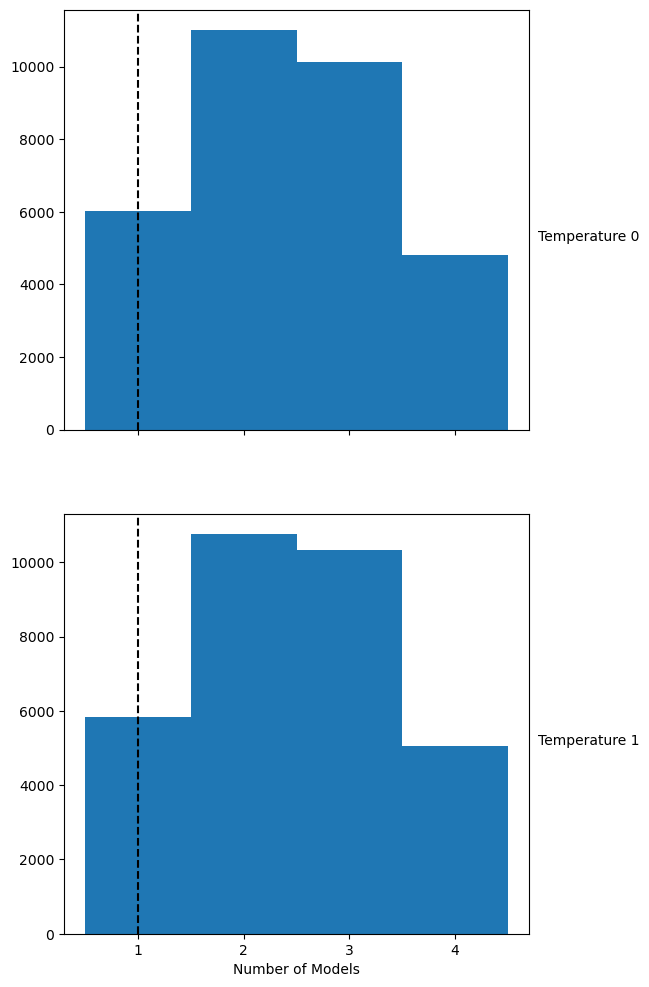

In [ ]:
import matplotlib.pyplot as plt

print(f'max ll: {ensemble.get_log_like().max()}')

print(ensemble.get_log_like())

nleaves = ensemble.get_nleaves()['cw']

bns = ( np.arange(nleaves_min-0.5, nleaves_max+1.5) )  # Just to make it pretty and center the bins

fig, ax = plt.subplots(ntemps, 1, sharex=True)
fig.set_size_inches(6, 12)
ax[-1].set_xlabel('Number of Models')
ax[-1].set_xticks(np.arange(nleaves_min,nleaves_max+1))

for temp, ax_t in enumerate(ax):
    ax_t.hist(nleaves[:, temp].flatten(), bins=bns)
    ax_t.text(1.02, 0.45, f'Temperature {temp}', horizontalalignment='left', transform=ax_t.transAxes)
    ax_t.axvline(1, color='k', linestyle='--')

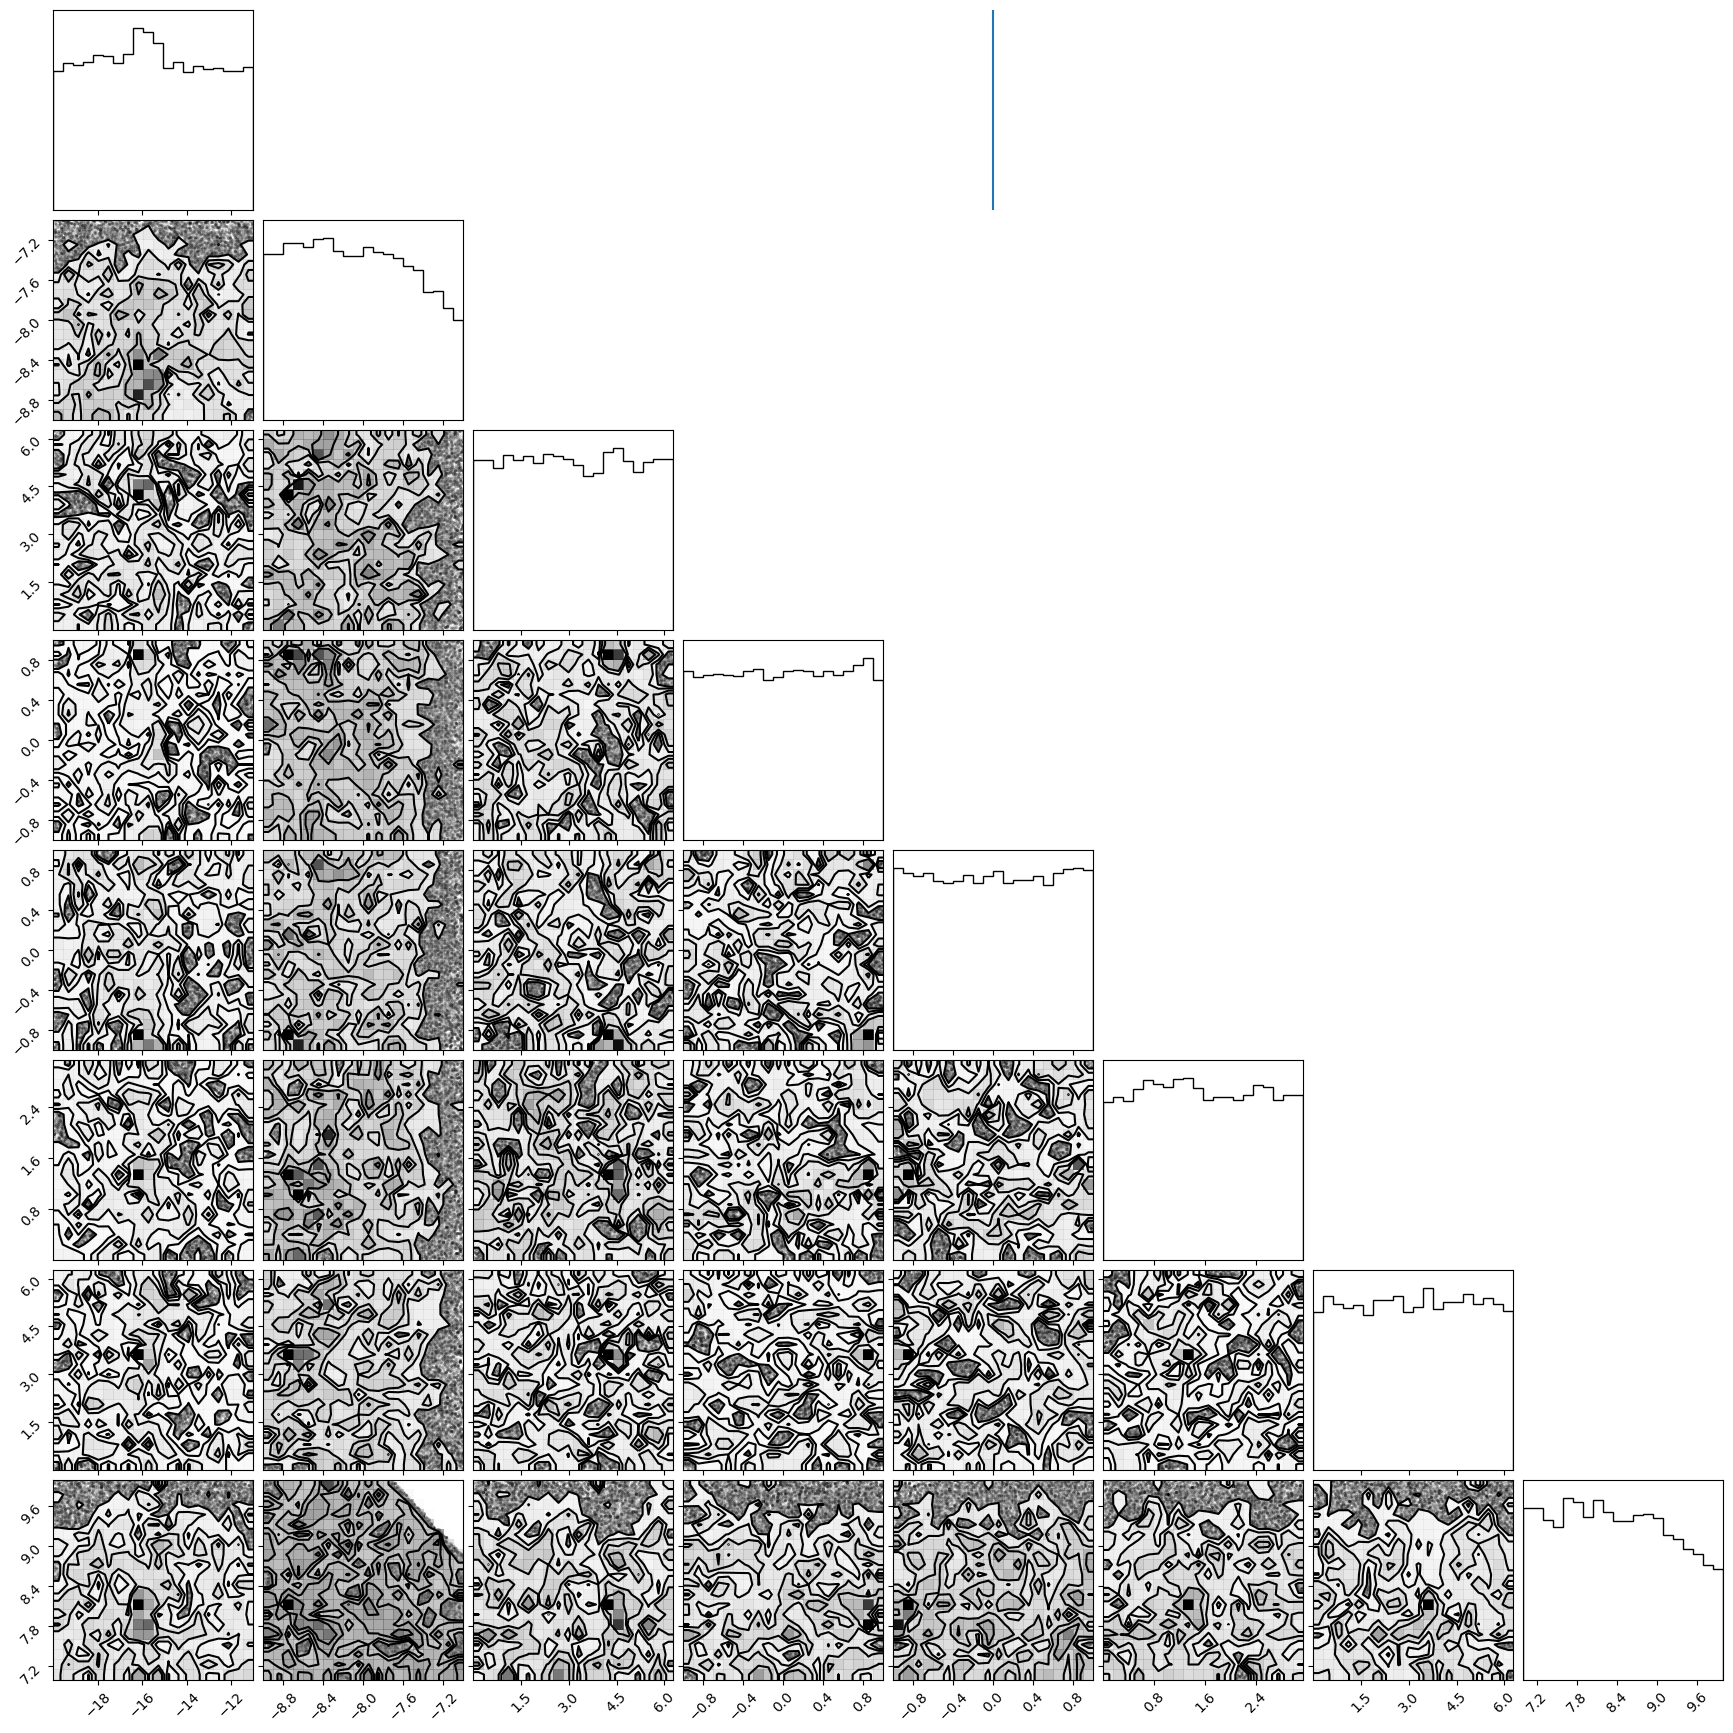

In [ ]:
import corner
samples = ensemble.get_chain()['cw'][:, 0].reshape(-1, ndim)

# same as ensemble.get_chain()['gauss'][ensemble.get_inds()['gauss']]
samples = samples[~np.isnan(samples[:, 0])]

means = np.asarray(np.array([best_guess]))[:, 1]

fig = corner.corner(samples, labels=base_names, show_titles=True, title_fmt=".2f", title_kwargs={"fontsize": 12})

ax = fig.axes

for mean in means:
    ax[4].axvline(mean)

## From here there's old stuff!

In [ ]:
class DiscoveryErynRJBridge:
    """
    Bridge between RJ_Discovery_model and Eryn's reversible jump MCMC.
    
    This class handles the interface between the cached likelihood models
    and Eryn's RJ sampler, managing parameter spaces of different dimensions.
    """
    
    def __init__(self, rj_model, priors_per_config=None, latex_labels=None):
        """
        Initialize the RJ bridge.
        
        Parameters
        ----------
        rj_model : RJ_Discovery_model
            The model with cached likelihoods
        priors_per_config : dict, optional
            Priors for each configuration. If None, uses uniform priors.
            Format: {config_tuple: {param_name: prior_spec, ...}}
        latex_labels : dict, optional
            LaTeX labels for parameters
        """
        self.rj_model = rj_model
        self.latex_labels = latex_labels or {}
        
        # Get all configurations and set up bridges for each
        self.configs = rj_model.get_all_configurations()
        self.bridges = {}
        self.config_to_key = {}
        
        # Create a standard DiscoveryErynBridge for each configuration
        for config in self.configs:
            config_key = tuple(sorted(config.items()))
            self.config_to_key[str(config)] = config_key
            
            likelihood = rj_model.get_likelihood_for_config(config)
            
            # Get priors for this configuration
            config_priors = None
            if priors_per_config:
                config_priors = priors_per_config.get(config_key, None)
            
            # Create bridge for this configuration
            bridge = DiscoveryErynBridge(
                likelihood, 
                priors=config_priors, 
                latex_labels=latex_labels
            )
            
            self.bridges[config_key] = bridge
    
    def get_bridge_for_config(self, config):
        """Get the Eryn bridge for a specific configuration."""
        config_key = tuple(sorted(config.items()))
        return self.bridges.get(config_key)
    
    def logL_rj(self, params, config):
        """
        Log-likelihood function compatible with Eryn RJ sampler.
        
        Parameters
        ----------
        params : dict or array
            Parameter values
        config : dict
            Model configuration (e.g., {'cw': 2})
        
        Returns
        -------
        float
            Log-likelihood value
        """
        # Get the appropriate bridge for this configuration
        bridge = self.get_bridge_for_config(config)
        
        if bridge is None:
            return -np.inf
        
        # Convert params to dict if needed
        if isinstance(params, np.ndarray):
            param_dict = bridge.unpack(params)
            param_dict.update(bridge.fixed_param_dict)
        else:
            param_dict = params
        
        return bridge._loglike_fn(param_dict)
    
    def get_all_bridges(self):
        """Return all configuration bridges."""
        return self.bridges
    
    def get_param_count_for_config(self, config):
        """Get number of parameters for a configuration."""
        bridge = self.get_bridge_for_config(config)
        return bridge.ndim if bridge else 0
    
    def print_config_summary(self):
        """Print a summary of all configurations and their parameter counts."""
        print("RJ Model Configuration Summary:")
        print("=" * 50)
        
        for config in self.configs:
            bridge = self.get_bridge_for_config(config)
            n_params = bridge.ndim
            n_fixed = bridge.n_fixed
            
            print(f"Configuration: {config}")
            print(f"  Sampled parameters: {n_params}")
            print(f"  Fixed parameters: {n_fixed}")
            print(f"  Total parameters: {n_params + n_fixed}")
            
            # Show some example parameter names
            if n_params > 0:
                param_names = bridge.sampled_names[:3]
                if len(bridge.sampled_names) > 3:
                    param_names.append("...")
                print(f"  Sample params: {param_names}")
            print()

# Create the RJ bridge
rj_bridge = DiscoveryErynRJBridge(rj_model, latex_labels=latex_labels)
rj_bridge.print_config_summary()

In [18]:
# Example of setting up Eryn RJ sampler

# You would need to install eryn with RJ support and import the RJ sampler
# For now, this shows the structure of how you'd set it up

def setup_eryn_rj_sampler(rj_bridge, nwalkers_per_model=10):
    """
    Set up Eryn's reversible jump sampler with the RJ bridge.
    
    This is a template showing how you'd interface with Eryn's RJ functionality.
    """
    
    # Get all configurations and their bridges
    bridges = rj_bridge.get_all_bridges()
    
    print("Setting up RJ sampler with the following models:")
    
    model_info = {}
    for i, (config_key, bridge) in enumerate(bridges.items()):
        config = dict(config_key)
        model_name = f"model_{i}"
        
        print(f"  {model_name}: {config} ({bridge.ndim} parameters)")
        
        # Store model information for Eryn
        model_info[model_name] = {
            'config': config,
            'bridge': bridge,
            'ndim': bridge.ndim,
            'nwalkers': nwalkers_per_model,
            'prior_container': bridge.eryn_prior_container
        }
    
    # Define log-likelihood function for RJ sampler
    def rj_loglike(params, model_name):
        """Log-likelihood function for RJ sampler."""
        # Get the config for this model
        model_data = model_info[model_name]
        config = model_data['config']
        bridge = model_data['bridge']
        
        # Convert theta to parameter dict and evaluate
        param_dict = bridge.unpack(params)
        param_dict.update(bridge.fixed_param_dict)
        
        return rj_bridge.rj_model.logL(param_dict)
    
    # This is where you'd create the actual Eryn RJ sampler
    # sampler = eryn.RJSampler(
    #     model_info,
    #     rj_loglike,
    #     **other_rj_kwargs
    # )
    
    print("\\nRJ sampler setup complete!")
    print("Model info structure:")
    for model_name, info in model_info.items():
        print(f"  {model_name}: {info['config']} - {info['ndim']} params, {info['nwalkers']} walkers")
    
    return model_info, rj_loglike

# Set up the RJ sampler structure
model_info, rj_loglike = setup_eryn_rj_sampler(rj_bridge)

# Test the RJ log-likelihood function
print("\\nTesting RJ log-likelihood:")
for model_name, info in model_info.items():
    bridge = info['bridge']
    if bridge.ndim > 0:  # Only test models with parameters to sample
        # Generate test parameters
        test_params = bridge.eryn_prior_container.rvs(size=1).flatten()
        logL_val = rj_loglike(test_params, model_name)
        print(f"  {model_name}: logL = {logL_val:.2f}")

NameError: name 'rj_bridge' is not defined

In [19]:
m.logL.params

NameError: name 'm' is not defined

In [ ]:
# Make a few latex labels for the base parameters
latex_labels = {
    "log10_h0":      r"$\\log_{10} h_0$",
    "log10_f0":      r"$\\log_{10} f_0 \\, [\\mathrm{Hz}]$",
    "ra":            r"$\\alpha \\, [\\mathrm{rad}]$",
    "sindec":        r"$\\sin(\\delta)$",
    "cosinc":        r"$\\cos(\\iota)$",
    "psi":           r"$\\psi \\, [\\mathrm{rad}]$",
    "phi_earth":     r"$\\phi_\\oplus \\, [\\mathrm{rad}]$",
    "log10_Mc":      r"$\\log_{10} \\mathcal{M}_c / M_\\odot$",
}

{'cw0_cosinc': 'cw0_cosinc', 'cw0_log10_Mc': 'cw0_log10_Mc', 'cw0_log10_f0': 'cw0_log10_f0', 'cw0_log10_h0': 'cw0_log10_h0', 'cw0_phi_earth': 'cw0_phi_earth', 'cw0_psi': 'cw0_psi', 'cw0_ra': 'cw0_ra', 'cw0_sindec': 'cw0_sindec', 'cw1_cosinc': 'cw1_cosinc', 'cw1_log10_Mc': 'cw1_log10_Mc', 'cw1_log10_f0': 'cw1_log10_f0', 'cw1_log10_h0': 'cw1_log10_h0', 'cw1_phi_earth': 'cw1_phi_earth', 'cw1_psi': 'cw1_psi', 'cw1_ra': 'cw1_ra', 'cw1_sindec': 'cw1_sindec', 'cw2_cosinc': 'cw2_cosinc', 'cw2_log10_Mc': 'cw2_log10_Mc', 'cw2_log10_f0': 'cw2_log10_f0', 'cw2_log10_h0': 'cw2_log10_h0', 'cw2_phi_earth': 'cw2_phi_earth', 'cw2_psi': 'cw2_psi', 'cw2_ra': 'cw2_ra', 'cw2_sindec': 'cw2_sindec'}


In [5]:
p0 = ds.sample_uniform(m.logL.params, n=1)
print(p0)
m.logL(p0)

{'B1855+09_rednoise_gamma': 2.1488333442649967, 'B1855+09_rednoise_log10_A': -19.135387548936, 'B1937+21_rednoise_gamma': 3.999120966130655, 'B1937+21_rednoise_log10_A': -18.447645215666796, 'B1953+29_rednoise_gamma': 1.0216247482159462, 'B1953+29_rednoise_log10_A': -16.534529627687977}


Array(428674.12032359, dtype=float64)

In [6]:

test_priors = {
    'B1855+09_rednoise_gamma': {'dist': 'uniform', 'min': 0, 'max': 7},
    'B1855+09_rednoise_log10_A': {'dist': 'uniform', 'min': -20, 'max': -11},
    'B1937+21_rednoise_gamma': {'dist': 'uniform', 'min': 0, 'max': 7},
    'B1937+21_rednoise_log10_A': {'dist': 'fixed', 'value': -13.5},
    'B1953+29_rednoise_gamma': {'dist': 'fixed', 'value': 3},
    'B1953+29_rednoise_log10_A': {'dist': 'uniform', 'min': -20, 'max': -11},
}

In [7]:
bridge = DiscoveryErynBridge(m, priors=test_priors, latex_labels=latex_labels)

In [8]:
print(bridge.sampled_prior_dict)
print(bridge.fixed_param_dict)
print(bridge.eryn_mapping)

{'B1855+09_rednoise_gamma': <eryn.prior.UniformDistribution object at 0x3ab5bfdc0>, 'B1855+09_rednoise_log10_A': <eryn.prior.UniformDistribution object at 0x3ab5bfdf0>, 'B1937+21_rednoise_gamma': <eryn.prior.UniformDistribution object at 0x3ab5bfe20>, 'B1953+29_rednoise_log10_A': <eryn.prior.UniformDistribution object at 0x3ab5bfe50>}
{'B1937+21_rednoise_log10_A': -13.5, 'B1953+29_rednoise_gamma': 3}
{'B1855+09_rednoise_gamma': 0, 'B1855+09_rednoise_log10_A': 1, 'B1937+21_rednoise_gamma': 2, 'B1953+29_rednoise_log10_A': 3}


In [9]:
ntemps = 3
tempering_kwargs=dict(ntemps=ntemps)

bridge.create_sampler(nwalkers=13, tempering_kwargs=tempering_kwargs)
bridge.sampler.backend.shape["model_0"]


(3, 13, 1, 4)

In [10]:
sampler = bridge.run_sampler(nsteps=500, burn=300, progress=True)

100%|██████████| 500/500 [00:08<00:00, 59.38it/s]


In [11]:
# Get the chain samples from the dict
samples = bridge.return_sampled_samples()
print(samples["names"])
print(samples["chain"].shape) 

['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A', 'B1937+21_rednoise_gamma', 'B1953+29_rednoise_log10_A']
(500, 3, 13, 1, 4)


/var/folders/6y/nrh4dqv10xxc55k_v95rl4l00000gn/T/ipykernel_58822/2166721642.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


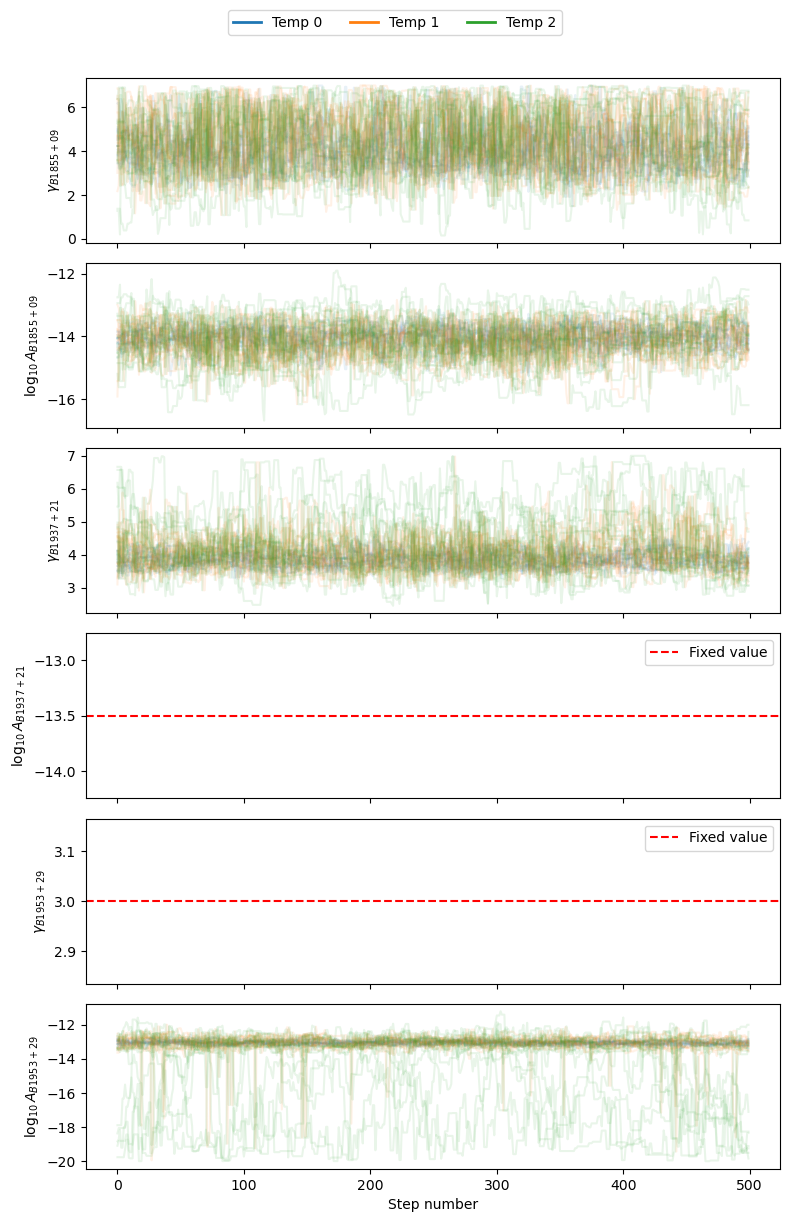

In [12]:
fig = bridge.plot_trace(plot_fixed=True)
fig.show()

/var/folders/6y/nrh4dqv10xxc55k_v95rl4l00000gn/T/ipykernel_58822/3008604745.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


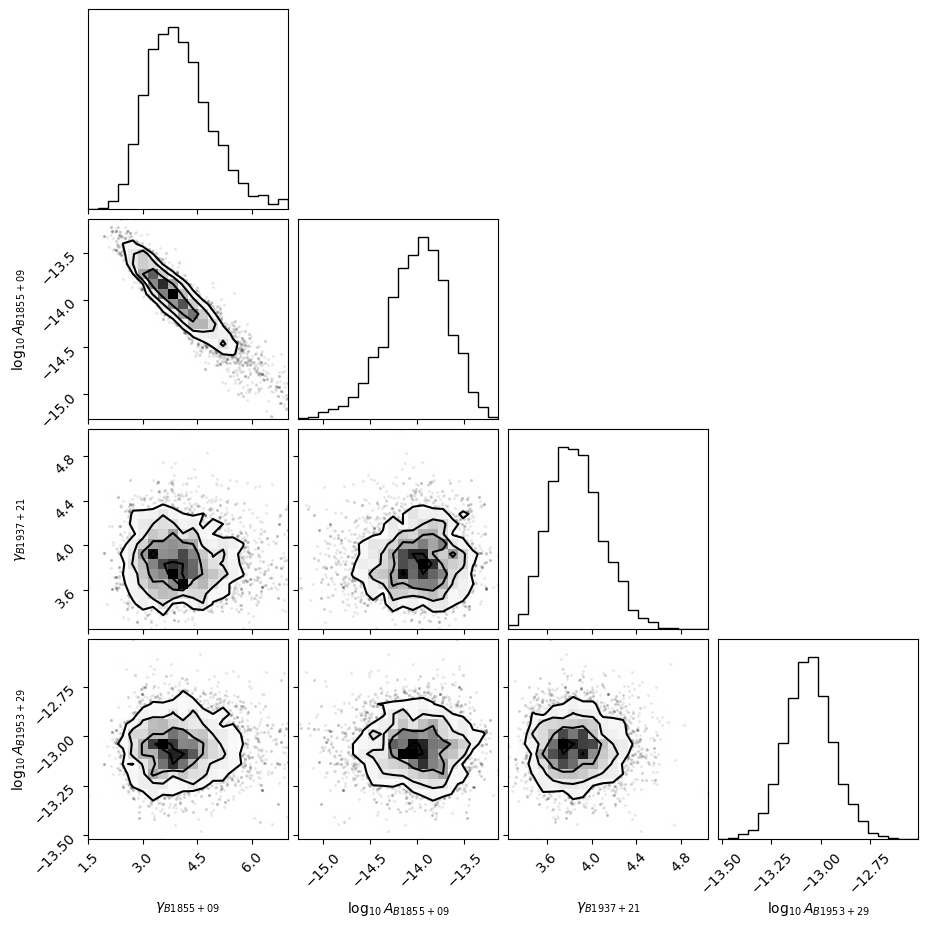

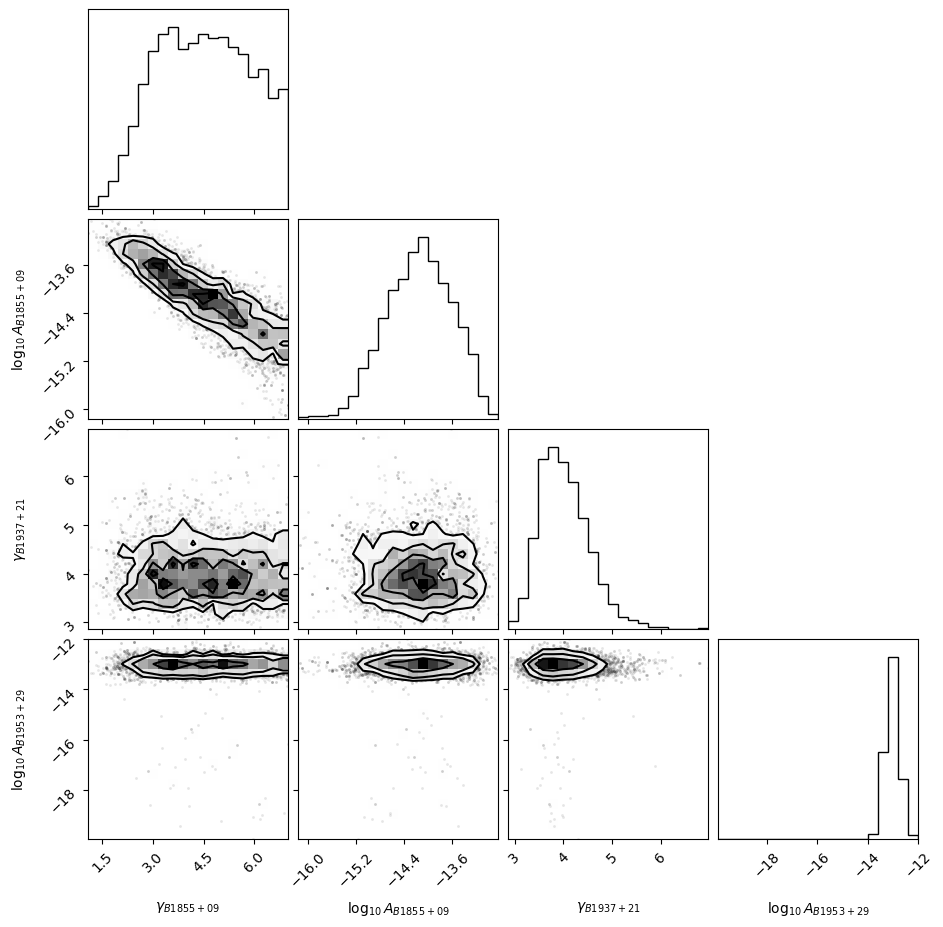

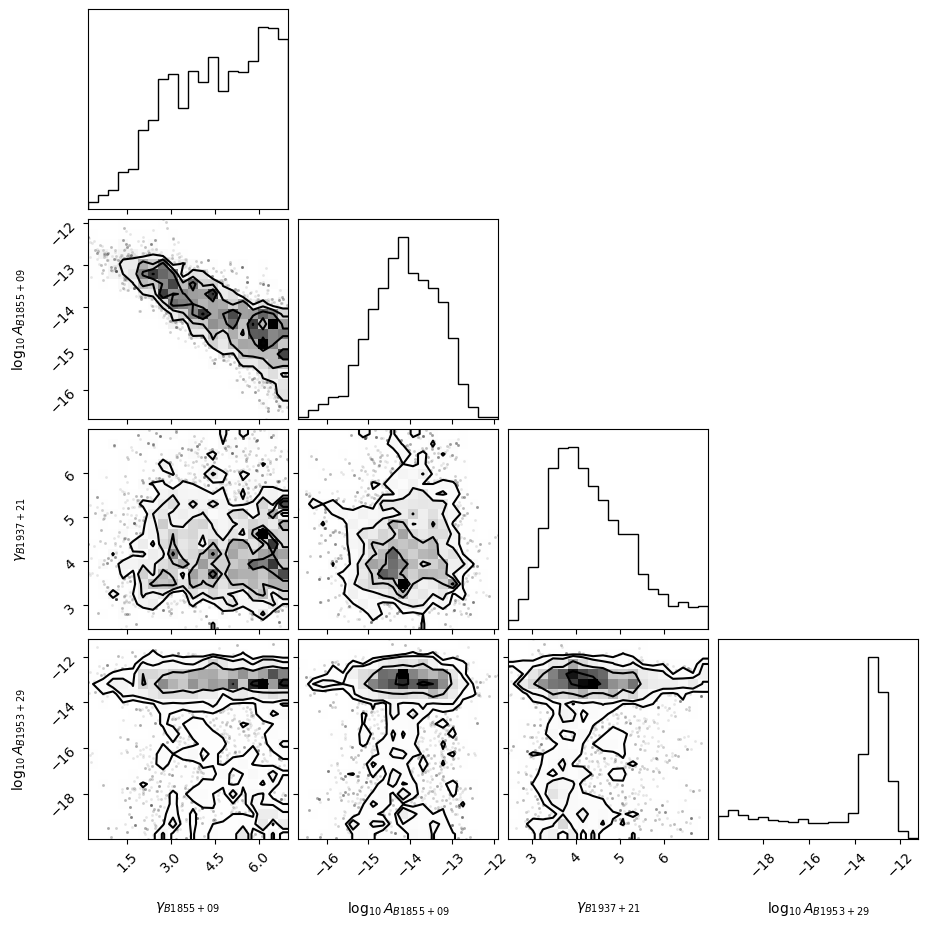

In [13]:
fig2 = bridge.plot_corner()
for fig in fig2:
    fig.show()